In [9]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

from minisom import MiniSom

import numpy as np
import scipy.io as scipio

from timeit import default_timer as timer
import time as tm

import seaborn as sns

import itertools

%matplotlib inline

%run minisom-master/minisom.py

In [3]:
def compute_dim(num_sample):
    dim = 5 * np.sqrt(num_sample)
    dim = np.int(np.sqrt(dim))
    if dim < 10: return 10
    else: return dim
    
def som_assemble(in_data, seed, dim, lr=0.5, sigma=2.5):
    # Initialization som and weights
    num_features = np.shape(in_data)[1]
    som = MiniSom(dim, dim, num_features, sigma=sigma, learning_rate=lr, 
                  neighborhood_function='gaussian', random_seed=seed)

    som.pca_weights_init(in_data)
    
    return som

def plot_som(som, norm_data, label, save=False, model_name='temp'):
    plt.figure(figsize=(9,7))
    # Plotting the response for each litho-class
    plt.pcolor(som.distance_map().T, cmap='bone_r')  
    # plotting the distance map as background
    plt.colorbar()

    for t, xx in zip(label, norm_data):
        w = som.winner(xx)  # getting the winner
        # palce a marker on the winning position for the sample xx
        plt.text(w[0]+.5, w[1]+.5, str(t),
                 color=plt.cm.rainbow(t/10.))
        
    plt.axis([0, som.get_weights().shape[0], 0, som.get_weights().shape[1]])
    if(save):
        save_dir = 'SOMs_results/' + model_name + '_plot.png'
        plt.savefig(save_dir)
        print('Plot saved at:', save_dir)
#     plt.show()
    
def write_param(model_name, dim, it, lr, re_inf, et, sigma):
    params = str(model_name) + '\n---' + \
             '\nseed,' + str(seed) + \
             '\ndim,' + str(dim) + \
             '\niterations,' + str(it) + \
             '\nlearning rate,' + str(lr) + \
             '\nsigma,' + str(sigma) + \
             '\ninf,' + str(re_inf) + \
             '\nelapsed time,' + str(et) + '\n\n'
    return params

def save_som(param_vals, som, report, c_matrix, model_name, grid=False, rand=False):
    #save report to file
    fdir, mode = '', ''
    if(grid):
        fdir = 'SOMs_results/grid_search/gridsearch_report2.csv'
        mode = 'a+'
    elif(rand):
        fdir = 'SOMs_results/random_search/randomsearch_report2.csv'
        mode = 'a+'
    else:
        fdir = 'SOMs_results/' + model_name + '_report.csv'
        mode = 'w'
    f1 = open(fdir, mode) 

    f1.write(param_vals) 
    f1.write(report) 
    f1.write('\nConfusion Matrix\n') 
    np.savetxt(f1, c_matrix,fmt='%i', delimiter=",")
    f1.write('\n\n--------------------\n\n')
    f1.close() #to change file access modes  
    print('Report saved at:', fdir)
    
    #pickle the model
    fdir = 'SOMs_results/' + model_name + '_model.p'
    with open(fdir, 'wb') as outfile:
        pickle.dump(som, outfile)
        
    print('Model saved at:', fdir)
    
def som_lloss_acc(y_pred_test, y_pred_train, y_test, y_train):
    y_pred_agg = []
    y_pred2_agg = []

    for num in list(y_pred_test):
        t = np.array(np.zeros(n_class))
        t[num-1] = 1
        y_pred_agg.append(list(t))

    for num in list(y_pred_train):
        t = np.array(np.zeros(n_class))
        t[num-1] = 1
        y_pred2_agg.append(list(t))
        
    lloss_test = log_loss(y_test, y_pred_agg, eps=1e-15)
    lloss_train = log_loss(y_train, y_pred2_agg, eps=1e-15)
    
    
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    
    print('====train====')
    print('lloss=', lloss_train)
    print('overall probability=', np.exp(-lloss_train))
    print('accuracy=', train_acc)

    print('====test====')
    print('lloss=', lloss_test)
    print('overall probability=', np.exp(-lloss_test))
    print('accuracy=', test_acc)
    
    return lloss_test, lloss_train, test_acc, train_acc

In [16]:
seed = 10

fdir = 'data/norm_data_xz.npy'
norm_data = np.load(fdir)

ldir = 'data/label.npy'
label = np.load(ldir)

# split data into train and test portion
X_train, X_test, y_train, y_test = train_test_split(norm_data, label, random_state=seed)

print("The size of train portion is:" , len(X_train))
print("The size of test portion is:" , len(X_test))

The size of train portion is: 16062
The size of test portion is: 5355


saved file: results/fulltestXZ_20190714-161259
dim: 34 iter: 4000 lr: 0.5124390316684666 sigma: 2.189655172413793

---------------
elapsed time: 5.769851054006722


KeyboardInterrupt: 

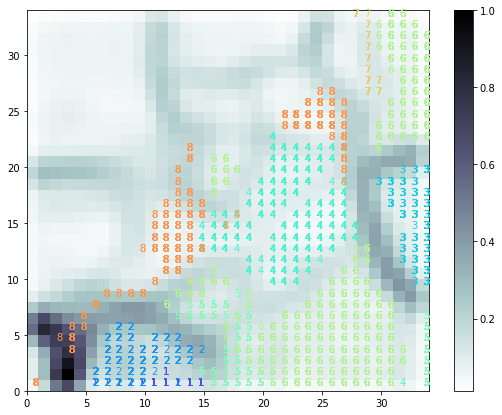

In [12]:
### test SOMs 
timestr = tm.strftime("%Y%m%d-%H%M%S")

# initialize hyperparameters
dim = 34
iter_cnt = 4000
lr = 0.5124390316684666
sigma = 2.189655172413793
re_inf = -9999

# define model name for saving
model_name = 'results/fulltestXZ_' + str(timestr)
print('saved file:', model_name)
print('dim:', dim, 'iter:', iter_cnt, 'lr:', lr, 'sigma:',sigma)
print('\n---------------')

som = som_assemble(norm_data, seed, dim, lr, sigma)

start = timer()
som.train_random(norm_data, iter_cnt, verbose=False)
end = timer()
elapsed_time = end - start
print('elapsed time:', elapsed_time)

# som.labels_map(X_train, y_train)
# y_pred = np.array(som.classify(X_test))

# report = classification_report(y_test, y_pred, digits=4)
# print(report)
# c_matrix = confusion_matrix(y_test, y_pred)
# print(c_matrix)

param_vals = write_param(model_name, dim, iter_cnt, lr, re_inf, elapsed_time, sigma)
# save_som(param_vals, som, report, c_matrix, model_name)
plot_som(som, norm_data, label, model_name=model_name, save=False)

In [ ]:
# som train_test
### test SOMs 
timestr = tm.strftime("%Y%m%d-%H%M%S")

# initialize hyperparameters
dim = 34
iter_cnt = 4000
lr = 0.5124390316684666
sigma = 2.189655172413793

# define model name for saving
model_name = 'results/fulltestXZ_' + str(timestr)
print('saved file:', model_name)
print('dim:', dim, 'iter:', iter_cnt, 'lr:', lr, 'sigma:',sigma)
print('\n---------------')

som_test = som_assemble(X_train, seed, dim, lr, sigma)

start = timer()
som_test.train_random(X_train, iter_cnt, verbose=False)
end = timer()
elapsed_time = end - start
print('elapsed time:', elapsed_time)

som_test.labels_map(X_train, y_train)
y_pred_test = np.array(som_test.classify(X_test))
y_pred_train = np.array(som_test.classify(X_train))

param_vals = write_param(model_name, dim, iter_cnt, lr, re_inf, elapsed_time, sigma)
# plot_som(som, norm_data, label, model_name=model_name, save=False)

In [21]:
som_lloss_acc(y_pred_test, y_pred_train, y_test, y_train)

====train====
lloss= 0.24083818679056943
overall probability= 0.7859687962326184
accuracy= 0.9930270202963516
====test====
lloss= 0.38053927307185315
overall probability= 0.683492720590346
accuracy= 0.9889822595704949


(0.38053927307185315,
 0.24083818679056943,
 0.9889822595704949,
 0.9930270202963516)

In [75]:
## parameter tuning
# grid search
def grid_search_som(init_num):
    
    dims = [-5, 0, 5, 10]
    dims += np.array(compute_dim(norm_data.shape[0]))
    idx = np.argwhere(dims<=0)
    if(idx.size!=0):
        dims = dims[idx[-1][0]:]
#    dim = [22, 27, 32, 37]
    iter_cnts = [2000, 4000, 5000, 6000]
    lr = [0.25, 0.5, 0.75]#, 1e-3, 1e-4]
    sigma = [1, 2, 2.5, 3, 4]

# # small grid test
#     dims = [5]
#     iter_cnts = [10, 20]
#     lr = [0.75]
#     sigma = [1]
    
    test_num = init_num
    
    hyperpara = [dims, iter_cnts, lr, sigma]
    hyperpara_perm = list(itertools.product(*hyperpara))
    
    best_acc = 0
    best_comb = []
    best_model = ''
    
    for comb in hyperpara_perm:
        print(comb[0]," ",comb[1], " ", comb[2], " ", comb[3])

        test_num += 1
        model_name = 'grid_search/grid_XZ_' + str(test_num)
        
        som = som_assemble(norm_data, seed, comb[0], lr=comb[2], sigma=comb[3])
        
        start = timer()
        som.train_random(X_train, comb[1], verbose=False)
        end = timer()
        elapsed_time = end - start
        
        som.labels_map(X_train, y_train)
        y_pred = np.array(som.classify(X_test))
        curr_acc = accuracy_score(y_test, y_pred)
        
        if(best_acc < curr_acc):
            best_acc = curr_acc
            best_comb = comb
            best_model = model_name
            print('current best model:', best_model)
            print('current best comb:', best_comb)
            print('current best acc:', best_acc)
            
        #save the current model
#         plot_som(som, norm_data, label, save=True, model_name=model_name)
        report = classification_report(y_test, y_pred, digits=4)
        c_matrix = confusion_matrix(y_test, y_pred)

        param_vals = write_param(model_name=model_name, dim=comb[0], it=comb[1], lr=comb[2], re_inf=re_inf, et=elapsed_time, sigma=comb[3])

        save_som(param_vals, som=som, report=report, c_matrix=c_matrix, model_name=model_name, grid=True)
    print('Best model found:', best_model)
    print('Best comb found:', best_comb)
    print('Best acc found:', best_acc)

    return best_comb

In [79]:
# run gridsearch to find best result
best_comb = grid_search_som(0)
print(best_comb)
dim, iter_cnt, lr, sigma = best_comb

22   2000   0.25   1
current best model: grid_search/grid_XZ_1
current best comb: (22, 2000, 0.25, 1)
current best acc: 0.9854341736694678
Report saved at: SOMs_results/grid_search/gridsearch_report2.csv
Model saved at: SOMs_results/grid_search/grid_XZ_1_model.p
22   2000   0.25   2
Report saved at: SOMs_results/grid_search/gridsearch_report2.csv
Model saved at: SOMs_results/grid_search/grid_XZ_2_model.p
22   2000   0.25   2.5
Report saved at: SOMs_results/grid_search/gridsearch_report2.csv
Model saved at: SOMs_results/grid_search/grid_XZ_3_model.p
22   2000   0.25   3
Report saved at: SOMs_results/grid_search/gridsearch_report2.csv
Model saved at: SOMs_results/grid_search/grid_XZ_4_model.p
22   2000   0.25   4
Report saved at: SOMs_results/grid_search/gridsearch_report2.csv
Model saved at: SOMs_results/grid_search/grid_XZ_5_model.p
22   2000   0.5   1
current best model: grid_search/grid_XZ_6
current best comb: (22, 2000, 0.5, 1)
current best acc: 0.9863678804855276
Report saved at: S

Report saved at: SOMs_results/grid_search/gridsearch_report2.csv
Model saved at: SOMs_results/grid_search/grid_XZ_52_model.p
22   6000   0.5   2.5
Report saved at: SOMs_results/grid_search/gridsearch_report2.csv
Model saved at: SOMs_results/grid_search/grid_XZ_53_model.p
22   6000   0.5   3
Report saved at: SOMs_results/grid_search/gridsearch_report2.csv
Model saved at: SOMs_results/grid_search/grid_XZ_54_model.p
22   6000   0.5   4
Report saved at: SOMs_results/grid_search/gridsearch_report2.csv
Model saved at: SOMs_results/grid_search/grid_XZ_55_model.p
22   6000   0.75   1
Report saved at: SOMs_results/grid_search/gridsearch_report2.csv
Model saved at: SOMs_results/grid_search/grid_XZ_56_model.p
22   6000   0.75   2
Report saved at: SOMs_results/grid_search/gridsearch_report2.csv
Model saved at: SOMs_results/grid_search/grid_XZ_57_model.p
22   6000   0.75   2.5
Report saved at: SOMs_results/grid_search/gridsearch_report2.csv
Model saved at: SOMs_results/grid_search/grid_XZ_58_model.

Report saved at: SOMs_results/grid_search/gridsearch_report2.csv
Model saved at: SOMs_results/grid_search/grid_XZ_107_model.p
27   6000   0.25   2.5
Report saved at: SOMs_results/grid_search/gridsearch_report2.csv
Model saved at: SOMs_results/grid_search/grid_XZ_108_model.p
27   6000   0.25   3
Report saved at: SOMs_results/grid_search/gridsearch_report2.csv
Model saved at: SOMs_results/grid_search/grid_XZ_109_model.p
27   6000   0.25   4
Report saved at: SOMs_results/grid_search/gridsearch_report2.csv
Model saved at: SOMs_results/grid_search/grid_XZ_110_model.p
27   6000   0.5   1
Report saved at: SOMs_results/grid_search/gridsearch_report2.csv
Model saved at: SOMs_results/grid_search/grid_XZ_111_model.p
27   6000   0.5   2
Report saved at: SOMs_results/grid_search/gridsearch_report2.csv
Model saved at: SOMs_results/grid_search/grid_XZ_112_model.p
27   6000   0.5   2.5
Report saved at: SOMs_results/grid_search/gridsearch_report2.csv
Model saved at: SOMs_results/grid_search/grid_XZ_113

Report saved at: SOMs_results/grid_search/gridsearch_report2.csv
Model saved at: SOMs_results/grid_search/grid_XZ_163_model.p
32   5000   0.75   3
Report saved at: SOMs_results/grid_search/gridsearch_report2.csv
Model saved at: SOMs_results/grid_search/grid_XZ_164_model.p
32   5000   0.75   4
Report saved at: SOMs_results/grid_search/gridsearch_report2.csv
Model saved at: SOMs_results/grid_search/grid_XZ_165_model.p
32   6000   0.25   1
Report saved at: SOMs_results/grid_search/gridsearch_report2.csv
Model saved at: SOMs_results/grid_search/grid_XZ_166_model.p
32   6000   0.25   2
Report saved at: SOMs_results/grid_search/gridsearch_report2.csv
Model saved at: SOMs_results/grid_search/grid_XZ_167_model.p
32   6000   0.25   2.5
Report saved at: SOMs_results/grid_search/gridsearch_report2.csv
Model saved at: SOMs_results/grid_search/grid_XZ_168_model.p
32   6000   0.25   3
Report saved at: SOMs_results/grid_search/gridsearch_report2.csv
Model saved at: SOMs_results/grid_search/grid_XZ_16

Report saved at: SOMs_results/grid_search/gridsearch_report2.csv
Model saved at: SOMs_results/grid_search/grid_XZ_219_model.p
37   5000   0.5   4
Report saved at: SOMs_results/grid_search/gridsearch_report2.csv
Model saved at: SOMs_results/grid_search/grid_XZ_220_model.p
37   5000   0.75   1
Report saved at: SOMs_results/grid_search/gridsearch_report2.csv
Model saved at: SOMs_results/grid_search/grid_XZ_221_model.p
37   5000   0.75   2
Report saved at: SOMs_results/grid_search/gridsearch_report2.csv
Model saved at: SOMs_results/grid_search/grid_XZ_222_model.p
37   5000   0.75   2.5
Report saved at: SOMs_results/grid_search/gridsearch_report2.csv
Model saved at: SOMs_results/grid_search/grid_XZ_223_model.p
37   5000   0.75   3
Report saved at: SOMs_results/grid_search/gridsearch_report2.csv
Model saved at: SOMs_results/grid_search/grid_XZ_224_model.p
37   5000   0.75   4
Report saved at: SOMs_results/grid_search/gridsearch_report2.csv
Model saved at: SOMs_results/grid_search/grid_XZ_225

In [81]:
def load_som_model(filename):
    loaded_model = pickle.load(open(filename, 'rb'))

    loaded_model.labels_map(X_train, y_train)
    y_pred = np.array(loaded_model.classify(X_test))
    report = classification_report(y_test, y_pred, digits=4)
    c_matrix = confusion_matrix(y_test, y_pred)
    test_acc = accuracy_score(y_test, y_pred)
    print("Test portion-----\n", report)    
    print(c_matrix)
    print("Accuracy:",test_acc)
    
    y_pred2 = np.array(loaded_model.classify(X_train))
    report2 = classification_report(y_train, y_pred2, digits=4)
    c_matrix2 = confusion_matrix(y_test, y_pred)
    train_acc = accuracy_score(y_train, y_pred2)
    print("Train portion-----\n", report2)
    print(c_matrix)
    print("Accuracy:",train_acc)
    
    return loaded_model

In [ ]:
# test load model
filename = 'SOMs_results/results/fulltestXZ_20190713-143151_model.p'
loaded_model = load_som_model(filename)

In [82]:
# test load model grid_search/grid_XZ_81 -- best with XZ
filename = 'SOMs_results/grid_search/grid_XZ_81_model.p'
loaded_model = load_som_model(filename)

Test portion-----
              precision    recall  f1-score   support

          1     1.0000    0.9452    0.9718        73
          2     0.9822    0.9910    0.9866       223
          3     1.0000    1.0000    1.0000       167
          4     0.9980    1.0000    0.9990       491
          5     1.0000    1.0000    1.0000       304
          6     1.0000    1.0000    1.0000      1055
          7     0.9965    1.0000    0.9982      1408
          8     1.0000    0.9957    0.9978       693
          9     1.0000    0.9989    0.9995       941

avg / total     0.9981    0.9981    0.9981      5355

[[  69    4    0    0    0    0    0    0    0]
 [   0  221    0    0    0    0    2    0    0]
 [   0    0  167    0    0    0    0    0    0]
 [   0    0    0  491    0    0    0    0    0]
 [   0    0    0    0  304    0    0    0    0]
 [   0    0    0    0    0 1055    0    0    0]
 [   0    0    0    0    0    0 1408    0    0]
 [   0    0    0    1    0    0    2  690    0]
 [   0    0

In [ ]:
# this is an old model, uses only 6 dim (no X and Z)
filename42 = 'SOMs_results/random_search/random_42_model.p'
loaded_model42 = load_som_model(filename42)

In [ ]:
def gen_param_grid(ideal_dim):
#     min_dim = ideal_dim - 5 if ideal_dim - 5 > 10 else 10
#     max_dim = ideal_dim * 2 if ideal_dim * 2 > 10 else 20
    min_dim, max_dim = 30, 35
    param_grid = {
        'dim': list(range(min_dim, max_dim+1)),
        'iter_cnt': list(range(4000, 5001, 200)),
        'learning_rate': list(np.logspace(np.log10(0.5), np.log10(0.75), base = 10, num = 100)),
        'sigma': list(np.linspace(2, 2.5, num=30)),
    }
    return param_grid

# random search
def random_search_som(init_num, param_grid, max_evals=10):
    
    test_num = init_num
    
    best_acc = 0
    best_comb = []
    best_model = ''
    random.seed(seed)
    
    for i in range(max_evals):
        
        random_params = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
        c_dim, c_it, c_lr, c_sig = list(random_params.values())
        
        print(c_dim," ",c_it, " ", c_lr, " ", c_sig)

        test_num += 1
        model_name = 'random_search/random_' + str(test_num)
        
        som = som_assemble(norm_data, seed, c_dim, lr=c_lr, sigma=c_sig)
        
        start = timer()
        som.train_random(X_train, c_it, verbose=False)
        end = timer()
        elapsed_time = end - start
        
        som.labels_map(X_train, y_train)
        y_pred = np.array(som.classify(X_test))
        curr_acc = accuracy_score(y_test, y_pred)
        
        if(best_acc < curr_acc):
            best_acc = curr_acc
            best_comb = comb
            best_model = model_name
            print('current best model:', best_model)
            print('current best comb:', best_comb)
            print('current best acc:', best_acc)
            
        #save the current model
#         plot_som(som, norm_data, label, save=True, model_name=model_name)
        report = classification_report(y_test, y_pred, digits=4)
        c_matrix = confusion_matrix(y_test, y_pred)

        param_vals = write_param(model_name=model_name, dim=c_dim, it=c_it, lr=c_lr, re_inf=re_inf, et=elapsed_time, sigma=c_sig)

        save_som(param_vals, som=som, report=report, c_matrix=c_matrix, model_name=model_name, rand=True)
        
    print('Best model found:', best_model)
    print('Best comb found:', best_comb)
    print('Best acc found:', best_acc)

    return best_comb, best_acc

In [ ]:
ideal_dim = compute_dim(norm_data.shape[0])
param_grid = gen_param_grid(ideal_dim)
# print(param_grid)
best_comb, best_acc = random_search_som(0, param_grid, max_evals=50)

In [ ]:
train_acc = accuracy_score(y_train, y_pred2)
test_acc = accuracy_score(y_test, y_pred)
print(train_acc,'\t', test_acc)

In [24]:
#test heatmap
import seaborn as sns
import pandas as pd

In [25]:
litos = np.asarray([
    'Water',
    'Siltstone',
    'Clastics',
    'Lavas',
    'Intrusions',
    'Metasediments',
    'Upper_crust',
    'Lower_crust',
    'Diorite',
    'Gabbro'])

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))         # Sample figsize in inches
sns.heatmap(c_matrix.astype(int),annot=True,linewidths=1, ax=ax, fmt='g', cmap="BuPu")

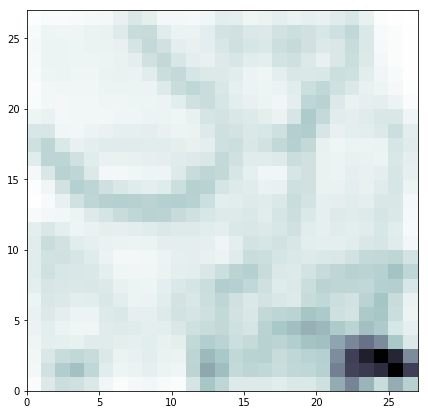

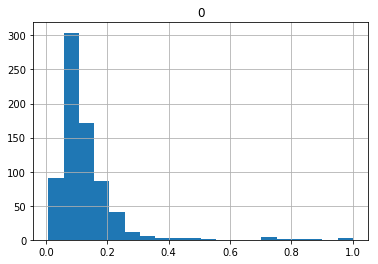

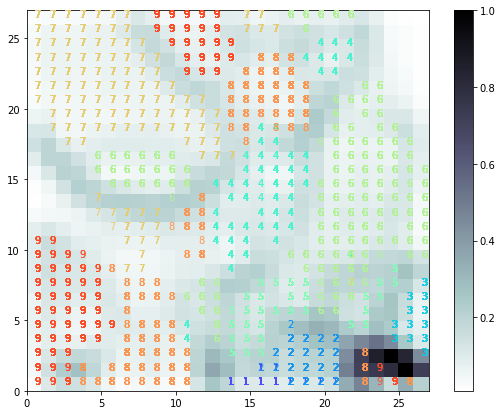

In [93]:
# image = plot_u_matrix(som)
image = plot_u_matrix(loaded_model)
plot_som(loaded_model, norm_data, label, model_name=model_name, save=False)

In [28]:
from skimage import filters
from skimage import measure
from scipy import ndimage
from scipy.spatial import distance
from collections import Counter


In [84]:
# check distance map
def plot_u_matrix(som):
    plt.figure(figsize=(7,7))
    plt.pcolor(som.distance_map().T, cmap='bone_r')  

    image = som.distance_map().T
    df = pd.DataFrame(image.flatten())
    df.describe()
    df.hist(bins=20)
    return image

def plot_class_som(som, norm_data, som_label):
    s_class = []
    for xx in norm_data:
        wx, wy = som.winner(xx)  # getting the winner neuron location
        s_class.append(som_label[wx][wy]) # get som's class label
        
    return s_class

def show_new_class(som_class, x, z):
    gridsize = (3, 2)
    fig = plt.figure(figsize=(16, 12))
    ax = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)

    sctr = ax.scatter(x=x, y=z, c=som_class, cmap='viridis_r')
    plt.colorbar(sctr, ax=ax)
    
    ax.invert_yaxis()
    plt.show()

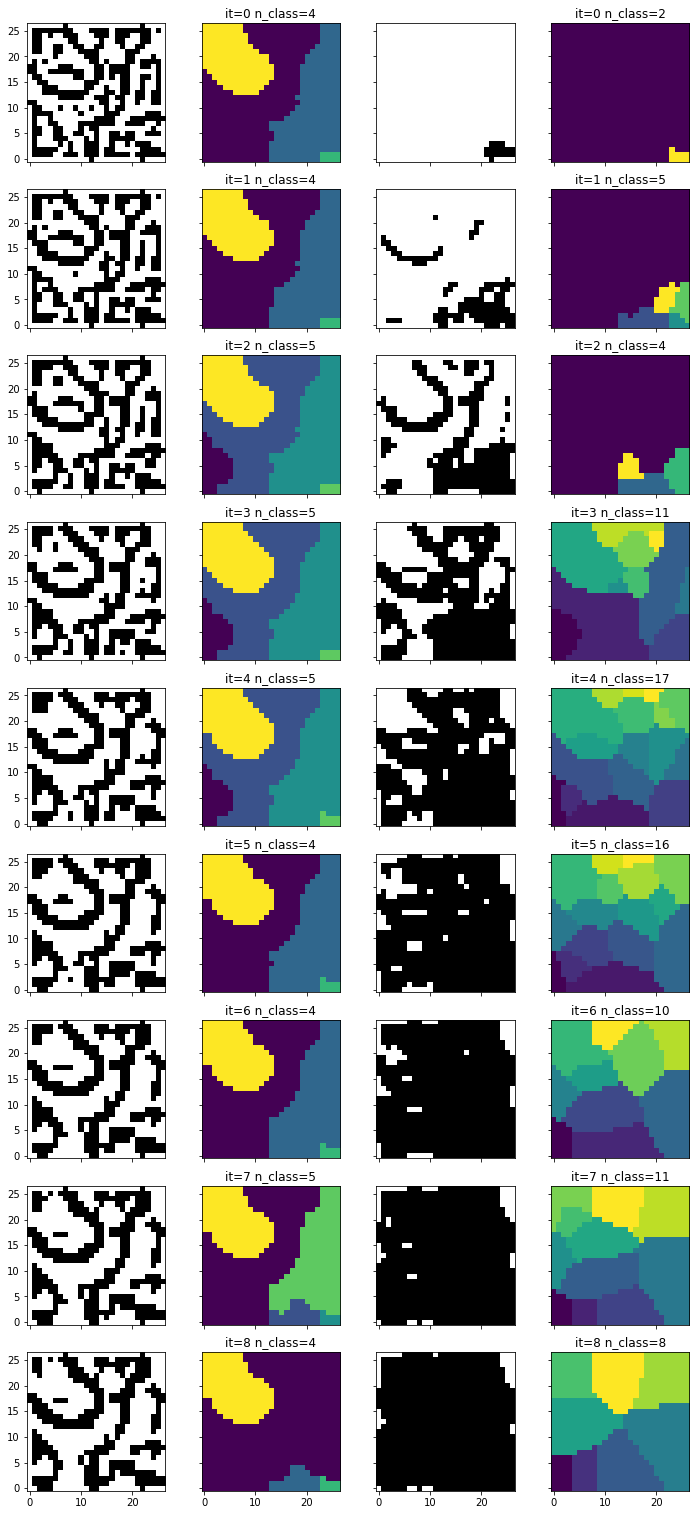

In [169]:
def closest_n(som_label):
    borders = np.array(np.where(som_label == 0)).T
    new_label = np.array(som_label)
    
    vals = np.where(som_label != 0)
    vals = np.array(vals).T
    
    for b in borders:
        c_idx = distance.cdist([b], vals).argmin()
        cl = som_label[vals[c_idx,0]][vals[c_idx,1]]
        
#         print(b, 'is nearest to', vals[c_idx], 'with class=', cl)
        new_label[b[0], b[1]] = cl
    
    return new_label

def watershed_level(image, levels, border_width=0.1):
    fig, axes = plt.subplots(ncols=4, nrows=levels, figsize=(12, levels*3), sharex=True, sharey=True)
    ax = axes.ravel()
    mask = []
    all_label = []
    
    mask2 = []
    all_label2 = []
    
    for i in range(levels):
        val = filters.threshold_local(image, block_size=3 + 2*i)

        mask.append(image < val)
        ax[i*4].imshow(mask[i], cmap=plt.cm.gray, origin='lower')
        all_label.append(measure.label(mask[i]))
#         all_label[i] = KNN(all_label[i])
        all_label[i] = closest_n(all_label[i])
        ax[i*4 + 1].imshow(all_label[i], origin='lower')
        ax[i*4 + 1].title.set_text('it={} n_class={}'.format(i, np.unique(all_label[i])[-1]))
        
        val2 = filters.threshold_otsu(image)
        mask2.append(image <= val2 / (i+1))
#         mask2.append(np.logical_or(image < val , image > val + border_width))
        ax[i*4 + 2].imshow(mask2[i], cmap=plt.cm.gray, origin='lower')
        all_label2.append(measure.label(mask2[i]))
#         all_label2[i] = KNN(all_label2[i])
        all_label2[i] = closest_n(all_label2[i])
        ax[i*4 + 3].imshow(all_label2[i], origin='lower')
        ax[i*4 + 3].title.set_text('it={} n_class={}'.format(i, np.unique(all_label2[i])[-1]))
        
    
    return all_label, all_label2

def KNN(som_label, k=5):
    borders = np.array(np.where(som_label == 0)).T
    new_label = np.array(som_label)
    
    vals = np.where(som_label != 0)
    vals = np.array(vals).T
    
    for b in borders:
        min_c_idx = distance.cdist([b], vals).argmin()
        dist = distance.cdist([b], vals)
        c_idx = np.argpartition(dist, k)
        c_idx = c_idx[0,:k]
        
        mins_idx = np.array(list(zip(vals[c_idx,0], vals[c_idx,1])))
        class_counter = Counter()
        for idx in mins_idx:
            class_counter[som_label[idx[0],idx[1]]] += 1
        cl = class_counter.most_common(1)[0][0]
        
        new_label[b[0], b[1]] = cl
    
    return new_label

all_label, all_label2 = watershed_level(image, 9)

In [38]:
x = data[:,-2]
z = data[:,-1]

In [179]:
def map_new_label(som, norm_data, som_label):
    # check distance map
    plt.figure(figsize=(3,3))
    plt.imshow(som_label, origin='lower', cmap='viridis_r')
    
    som_class = plot_class_som(som, norm_data, som_label)
    show_new_class(som_class, x, z)

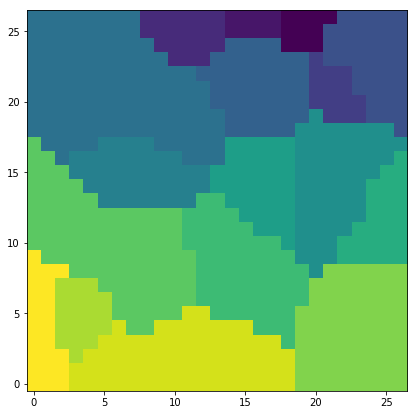

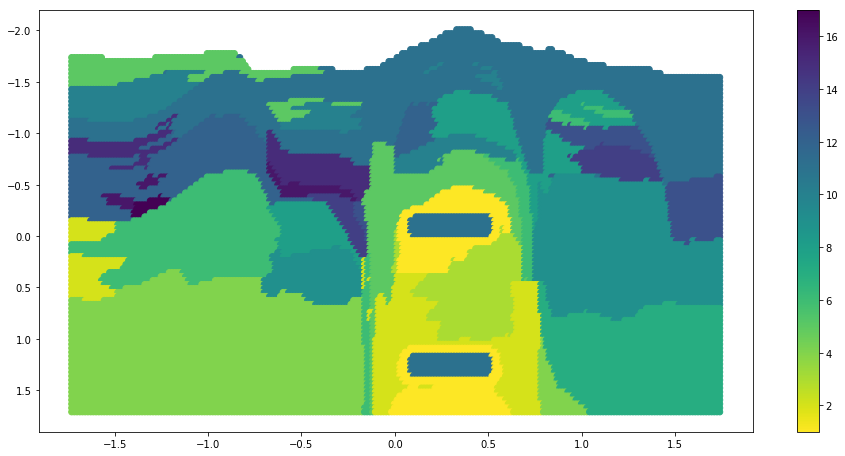

In [176]:
map_new_label(loaded_model, norm_data, all_label2[4])

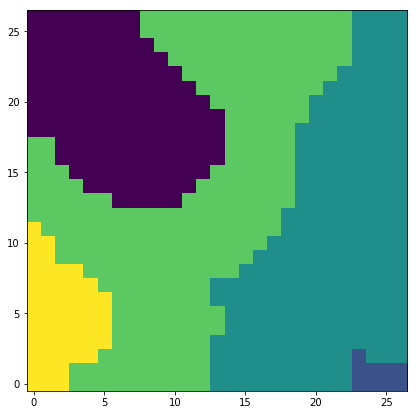

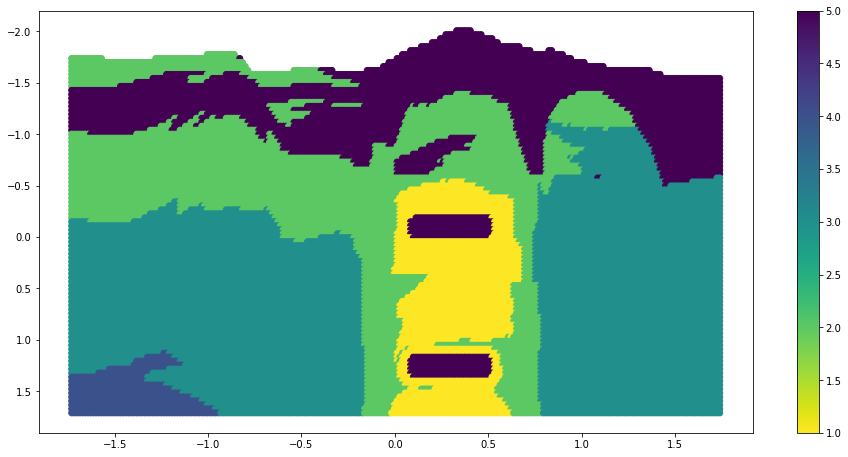

In [178]:
map_new_label(loaded_model, norm_data, all_label[4])

In [ ]:
som_class3 = np.array(som_class3)
n_class2 = len(np.unique(som_class3))

data_info2 = plot_hist(data[:,:-2], np.reshape(som_class3, (som_class3.shape[0],1)), n_class2, titles)
data_info2

In [ ]:
som_class = np.array(som_class)
n_class3 = len(np.unique(som_class))
titles = ['Class', 'Vp (m/s)', 'Vs (m/s)', 'Density (kg/m$^3$)', 'Vp/Vs', 'Qp', 'Qs', 'X', 'Z']
data_info3 = plot_hist(data[:,:-2], np.reshape(som_class, (som_class.shape[0],1)), n_class3, titles)
data_info3

In [ ]:
print(X_train.shape, X_test.shape)#, y_train, y_test

In [ ]:
#naive bayes
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred3 = gnb.fit(X_train, y_train).predict(X_train)
y_pred4 = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0],(y_train != y_pred3).sum()))
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0],(y_test != y_pred4).sum()))

naive_train_acc = 100 * (y_train == y_pred3).sum() / X_train.shape[0]
naive_test_acc = 100 * (y_test == y_pred4).sum() / X_test.shape[0]
print("Accuracy of : %.2f" % (naive_train_acc))
print("Accuracy of : %.2f" % (naive_test_acc))

In [ ]:
print(X_test[:,-1])
# show_new_class(som_class2)

In [ ]:
#multinomial naive bayes
from sklearn.naive_bayes import MultinomialNB

nb_norm = minMaxNorm(norm_data)

# X = np.random.randint(5, size=(6, 100))
# y = np.array([1, 2, 3, 4, 5, 6])
clf = MultinomialNB()

X_train_mnb, X_test_mnb, y_train_mnb, y_test_mnb = train_test_split(nb_norm, label, random_state=seed)

y_pred5 = clf.fit(X_train_mnb, y_train_mnb).predict(X_train_mnb)
y_pred6 = clf.fit(X_train_mnb, y_train_mnb).predict(X_test_mnb)

mnb_train_acc = 100 * (y_train_mnb == y_pred5).sum() / X_train_mnb.shape[0]
mnb_test_acc = 100 * (y_test_mnb == y_pred6).sum() / X_test_mnb.shape[0]
print("Train Accuracy of : %.2f" % (mnb_train_acc))
print("Test Accuracy of : %.2f" % (mnb_test_acc))

In [ ]:
def minMaxNorm(in_data):
    in_data = (in_data - in_data.min()) / (in_data.max() + in_data.min())
    return in_data